# Skin Cancer Classifier using Dermatoscopic Images of Pigmented Lesions


## Data Loading and Splitting 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=e1a562fd5d83b8339be5fbbd7131f2a42b1e5a08a2476e75d7579df4ca6ae3db
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"valentinamanferrari","key":"6124c1d86b4b80417e8a6672051eda5e"}'}

In [4]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 98% 319M/325M [00:05<00:00, 66.0MB/s]
100% 325M/325M [00:05<00:00, 63.5MB/s]


In [7]:
! mkdir dataset

In [ ]:
! unzip skin-cancer-malignant-vs-benign.zip -d dataset

In [9]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Data Loading

train_path ='/content/dataset/train'
test_path='/content/dataset/test'

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] 
        label_class = classes[label_index] 
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes,batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """
    classes = ("malignant", "benign")

    ########################################################################
    # Transfrom images to tensors
    transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

    train_dataset = torchvision.datasets.ImageFolder(train_path, transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(test_path, transform=transform)

    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(train_dataset, classes, target_classes)
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.90) #10% for validation
    
    # split into training, validation
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              num_workers = 1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                              num_workers=1, shuffle=True)
    
    return train_loader, valid_loader, test_loader, classes

In [10]:
train,val,test,classes = get_data_loader(target_classes=["malignant", "benign"], batch_size=1)

In [22]:
count_m = 0
for k in range(len(dataset)):
  for images, labels in dataset:
    if labels[k] == "malignant":
      count_m ++

NameError: ignored

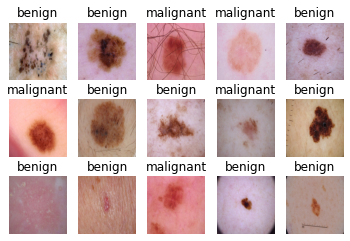

In [ ]:
# Plot some examples from training set 

k = 0
for images, labels in train:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    plt.subplot(3, 5, k+1)
    # Add the label as title for image
    plt.title(classes[labels[0]])
    plt.axis('off')
    plt.imshow(img)
    k += 1
    if k > 14:
        break

In [ ]:
print("Length of training dataset: ", len(train))
print("Length of validation dataset: ", len(val))
print("Length of testing dataset: ", len(test))

print("\nWe have opted for a 70/30 split, with approximately 10% validation and 20% testing.")


Length of training dataset:  2373
Length of validation dataset:  264
Length of testing dataset:  660

We have opted for a 70/30 split, with approximately 10% validation and 20% testing.


## Baseline Model 

In [ ]:
class CNN(nn.Module):
      def __init__(self):
          super(CNN, self).__init__()
          self.name = "cnn"
          self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = 5, padding = 1) 
          self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) 
          self.conv2 = nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = 5, padding = 1) 
          self.fc1 = nn.Linear(10*54*54, 120)
          self.fc2 = nn.Linear(120, 84) 
          self.fc3 = nn.Linear(84,2) # malignant or benign

      def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 10*54*54)
          x = F.relu(self.fc1(x))
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x

In [ ]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, batch_size=64, num_epochs=50,learning_rate=0.01):
    train_loader,val_loader,test_loader,classes = get_data_loader(target_classes=["malignant","benign"],batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
        print("Epoch {} - Training Accuracy: {}, Validation Accuracy: {}".format(epoch, train_acc[epoch], val_acc[epoch]))
        n += 1
            

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
Epoch 0 - Training Accuracy: 0.6451748841129372, Validation Accuracy: 0.6515151515151515
Epoch 1 - Training Accuracy: 0.7290349768225874, Validation Accuracy: 0.7537878787878788
Epoch 2 - Training Accuracy: 0.7454698693636747, Validation Accuracy: 0.7272727272727273
Epoch 3 - Training Accuracy: 0.7492625368731564, Validation Accuracy: 0.8068181818181818
Epoch 4 - Training Accuracy: 0.7543194268857986, Validation Accuracy: 0.7992424242424242
Epoch 5 - Training Accuracy: 0.8120522545301306, Validation Accuracy: 0.8181818181818182
Epoch 6 - Training Accuracy: 0.81078803202697, Validation Accuracy: 0.8068181818181818
Epoch 7 - Training Accuracy: 0.8209018120522545, Validation Accuracy: 0.8181818181818182
Epoch 8 - Training Accuracy: 0.8230088495575221, Validation Accuracy: 0.8143939393939394
Epoch 9 - Training Accuracy: 0.7796038769490097, Validation Accuracy: 0.7727272727272727
Epoch 10 - Training Accuracy: 0.8175305520438264, Validation Accuracy: 0

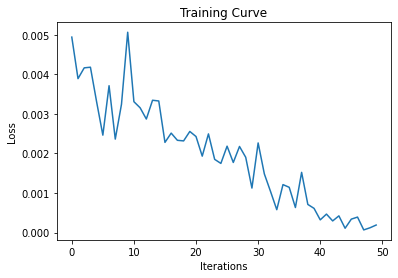

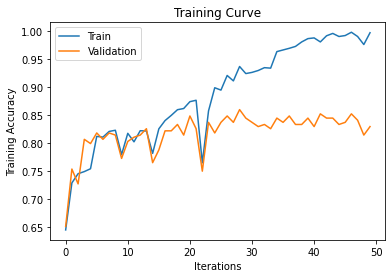

Final Training Accuracy: 0.9970501474926253
Final Validation Accuracy: 0.8295454545454546


In [ ]:
use_cuda = True

model = CNN()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model with batch size 128 lr 0.001
train(model,batch_size=128, num_epochs=50,learning_rate=0.001)

In [ ]:
train_loader,val_loader,test_loader,classes = get_data_loader(["malignant","benign"],batch_size=128)
test_acc = get_accuracy(model, test_loader)
print("Test Accuracy :", test_acc)

## ResNet 18

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch 0 - Training Accuracy: 0.7960387694900969, Validation Accuracy: 0.7954545454545454
Epoch 1 - Training Accuracy: 0.7901390644753477, Validation Accuracy: 0.8295454545454546
Epoch 2 - Training Accuracy: 0.8179519595448799, Validation Accuracy: 0.8181818181818182
Epoch 3 - Training Accuracy: 0.8251158870627897, Validation Accuracy: 0.8484848484848485
Epoch 4 - Training Accuracy: 0.8364938895912347, Validation Accuracy: 0.8560606060606061
Epoch 5 - Training Accuracy: 0.8407079646017699, Validation Accuracy: 0.8295454545454546
Epoch 6 - Training Accuracy: 0.8575642646439107, Validation Accuracy: 0.8636363636363636
Epoch 7 - Training Accuracy: 0.8390223345975558, Validation Accuracy: 0.8333333333333334
Epoch 8 - Training Accuracy: 0.8630425621576064, Validation Accuracy: 0.8636363636363636
Epoch 9 - Training Accuracy: 0.8596713021491783, Validation Accuracy: 0.8560606060606061
Epoch 10 - Training Accuracy: 0.8710493046776233, Validation Accuracy: 0.8674242424242424
Epoch 11 - Training 

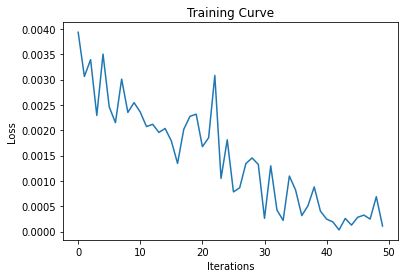

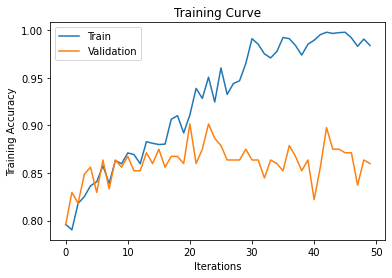

Final Training Accuracy: 0.9839865149599663
Final Validation Accuracy: 0.8598484848484849


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=False)
train(resnet18_model.cuda(), batch_size=128, num_epochs=50,learning_rate=0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch 0 - Training Accuracy: 0.8411293721028235, Validation Accuracy: 0.8295454545454546
Epoch 1 - Training Accuracy: 0.832701222081753, Validation Accuracy: 0.8522727272727273
Epoch 2 - Training Accuracy: 0.8714707121786768, Validation Accuracy: 0.8712121212121212
Epoch 3 - Training Accuracy: 0.9043404972608512, Validation Accuracy: 0.9015151515151515
Epoch 4 - Training Accuracy: 0.9275179098187948, Validation Accuracy: 0.9090909090909091
Epoch 5 - Training Accuracy: 0.9367888748419722, Validation Accuracy: 0.9053030303030303
Epoch 6 - Training Accuracy: 0.967551622418879, Validation Accuracy: 0.9090909090909091
Epoch 7 - Training Accuracy: 0.9616519174041298, Validation Accuracy: 0.8939393939393939
Epoch 8 - Training Accuracy: 0.9498525073746312, Validation Accuracy: 0.8977272727272727
Epoch 9 - Training Accuracy: 0.9801938474504847, Validation Accuracy: 0.9128787878787878
Epoch 10 - Training Accuracy: 0.9835651074589128, Validation Accuracy: 0.8863636363636364
Epoch 11 - Training Ac

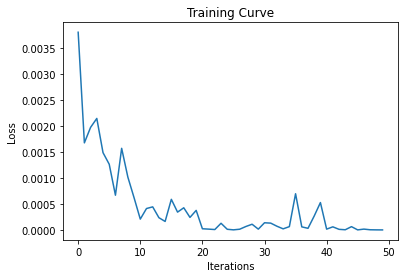

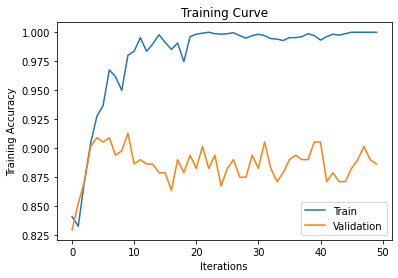

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8863636363636364


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=128, num_epochs=50,learning_rate=0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch 0 - Training Accuracy: 0.8600927096502318, Validation Accuracy: 0.8598484848484849
Epoch 1 - Training Accuracy: 0.9435313948588285, Validation Accuracy: 0.9128787878787878
Epoch 2 - Training Accuracy: 0.9810366624525917, Validation Accuracy: 0.9015151515151515
Epoch 3 - Training Accuracy: 0.9957859249894648, Validation Accuracy: 0.9128787878787878
Epoch 4 - Training Accuracy: 0.9987357774968394, Validation Accuracy: 0.9242424242424242
Epoch 5 - Training Accuracy: 0.999157184997893, Validation Accuracy: 0.9242424242424242
Epoch 6 - Training Accuracy: 0.9995785924989464, Validation Accuracy: 0.9053030303030303
Epoch 7 - Training Accuracy: 1.0, Validation Accuracy: 0.9242424242424242
Epoch 8 - Training Accuracy: 1.0, Validation Accuracy: 0.9242424242424242
Epoch 9 - Training Accuracy: 1.0, Validation Accuracy: 0.9242424242424242
Epoch 10 - Training Accuracy: 1.0, Validation Accuracy: 0.9204545454545454
Epoch 11 - Training Accuracy: 1.0, Validation Accuracy: 0.9242424242424242
Epoch

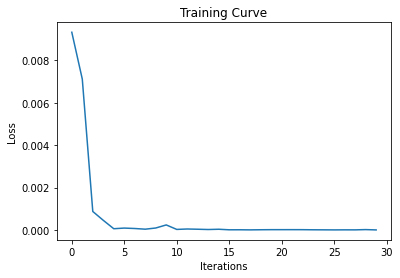

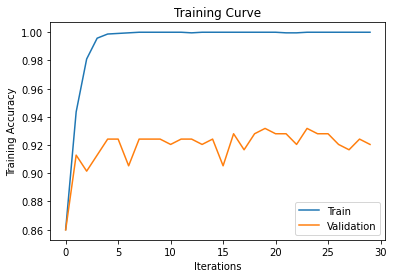

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9204545454545454


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=128, num_epochs=30,learning_rate=0.0001)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch 0 - Training Accuracy: 0.9110830172777076, Validation Accuracy: 0.8901515151515151
Epoch 1 - Training Accuracy: 0.9506953223767383, Validation Accuracy: 0.8825757575757576
Epoch 2 - Training Accuracy: 0.9818794774546987, Validation Accuracy: 0.8863636363636364
Epoch 3 - Training Accuracy: 0.978929624947324, Validation Accuracy: 0.8977272727272727
Epoch 4 - Training Accuracy: 0.9890434049726086, Validation Accuracy: 0.9204545454545454
Epoch 5 - Training Accuracy: 0.9983143699957859, Validation Accuracy: 0.9242424242424242
Epoch 6 - Training Accuracy: 0.9970501474926253, Validation Accuracy: 0.9128787878787878
Epoch 7 - Training Accuracy: 0.9890434049726086, Validation Accuracy: 0.9128787878787878
Epoch 8 - Training Accuracy: 0.9919932574799831, Validation Accuracy: 0.8939393939393939
Epoch 9 - Training Accuracy: 0.9962073324905183, Validation Accuracy: 0.8825757575757576


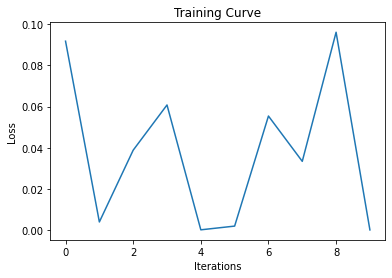

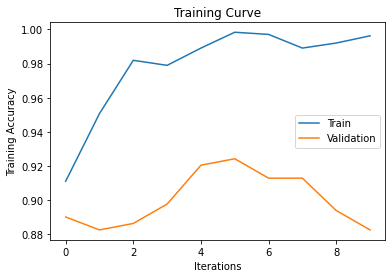

Final Training Accuracy: 0.9962073324905183
Final Validation Accuracy: 0.8825757575757576


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=64, num_epochs=10, learning_rate=0.0001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch 0 - Training Accuracy: 0.7800252844500632, Validation Accuracy: 0.8143939393939394
Epoch 1 - Training Accuracy: 0.8853771597134429, Validation Accuracy: 0.8522727272727273
Epoch 2 - Training Accuracy: 0.9443742098609356, Validation Accuracy: 0.8598484848484849
Epoch 3 - Training Accuracy: 0.976401179941003, Validation Accuracy: 0.8901515151515151
Epoch 4 - Training Accuracy: 0.9633375474083439, Validation Accuracy: 0.8484848484848485
Epoch 5 - Training Accuracy: 0.9528023598820059, Validation Accuracy: 0.821969696969697
Epoch 6 - Training Accuracy: 0.9759797724399494, Validation Accuracy: 0.8484848484848485
Epoch 7 - Training Accuracy: 0.9721871049304678, Validation Accuracy: 0.8295454545454546
Epoch 8 - Training Accuracy: 0.9966287399915719, Validation Accuracy: 0.8522727272727273
Epoch 9 - Training Accuracy: 0.9932574799831437, Validation Accuracy: 0.8560606060606061
Epoch 10 - Training Accuracy: 0.9941002949852508, Validation Accuracy: 0.8484848484848485
Epoch 11 - Training Ac

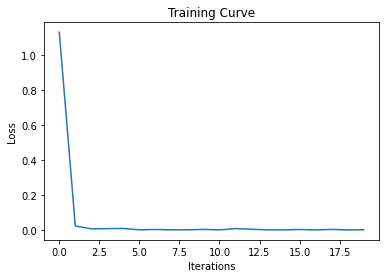

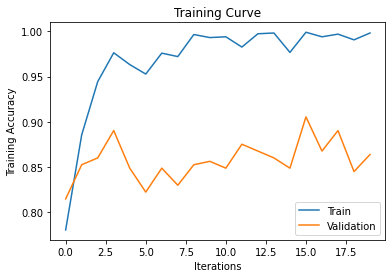

Final Training Accuracy: 0.9983143699957859
Final Validation Accuracy: 0.8636363636363636


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=1, num_epochs=20, learning_rate=0.0001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch 0 - Training Accuracy: 0.8445006321112516, Validation Accuracy: 0.8825757575757576
Epoch 1 - Training Accuracy: 0.8541930046354825, Validation Accuracy: 0.8484848484848485
Epoch 2 - Training Accuracy: 0.8044669195111673, Validation Accuracy: 0.8257575757575758
Epoch 3 - Training Accuracy: 0.8293299620733249, Validation Accuracy: 0.8295454545454546
Epoch 4 - Training Accuracy: 0.8845343447113359, Validation Accuracy: 0.8787878787878788
Epoch 5 - Training Accuracy: 0.8807416772018541, Validation Accuracy: 0.8825757575757576
Epoch 6 - Training Accuracy: 0.8710493046776233, Validation Accuracy: 0.8636363636363636
Epoch 7 - Training Accuracy: 0.8744205646860514, Validation Accuracy: 0.8560606060606061
Epoch 8 - Training Accuracy: 0.8727349346818374, Validation Accuracy: 0.8598484848484849
Epoch 9 - Training Accuracy: 0.8664138221660346, Validation Accuracy: 0.8484848484848485
Epoch 10 - Training Accuracy: 0.9165613147914032, Validation Accuracy: 0.8863636363636364
Epoch 11 - Training 

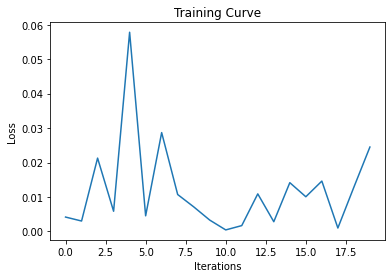

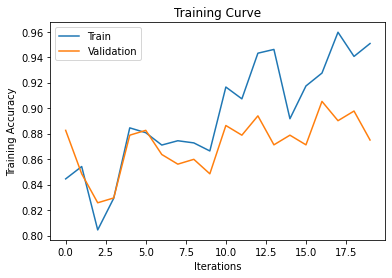

Final Training Accuracy: 0.9506953223767383
Final Validation Accuracy: 0.875


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=64, num_epochs=20, learning_rate=0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch 0 - Training Accuracy: 0.8925410872313527, Validation Accuracy: 0.8560606060606061
Epoch 1 - Training Accuracy: 0.9199325747998315, Validation Accuracy: 0.8825757575757576
Epoch 2 - Training Accuracy: 0.9730299199325748, Validation Accuracy: 0.9090909090909091
Epoch 3 - Training Accuracy: 0.9898862199747156, Validation Accuracy: 0.8939393939393939
Epoch 4 - Training Accuracy: 0.9987357774968394, Validation Accuracy: 0.9204545454545454
Epoch 5 - Training Accuracy: 0.9987357774968394, Validation Accuracy: 0.9090909090909091
Epoch 6 - Training Accuracy: 0.999157184997893, Validation Accuracy: 0.9204545454545454
Epoch 7 - Training Accuracy: 0.999157184997893, Validation Accuracy: 0.9166666666666666
Epoch 8 - Training Accuracy: 0.989464812473662, Validation Accuracy: 0.9204545454545454
Epoch 9 - Training Accuracy: 0.9924146649810367, Validation Accuracy: 0.9166666666666666
Epoch 10 - Training Accuracy: 0.9995785924989464, Validation Accuracy: 0.9053030303030303
Epoch 11 - Training Acc

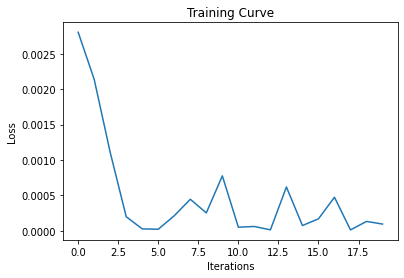

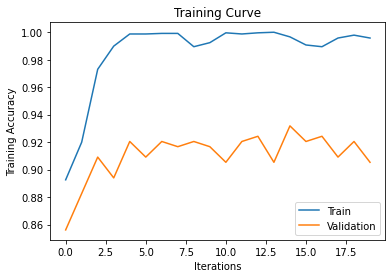

Final Training Accuracy: 0.9957859249894648
Final Validation Accuracy: 0.9053030303030303


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=128, num_epochs=20, learning_rate=0.0003)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch 0 - Training Accuracy: 0.8853771597134429, Validation Accuracy: 0.8863636363636364
Epoch 1 - Training Accuracy: 0.9469026548672567, Validation Accuracy: 0.9090909090909091
Epoch 2 - Training Accuracy: 0.9709228824273072, Validation Accuracy: 0.8863636363636364
Epoch 3 - Training Accuracy: 0.9873577749683944, Validation Accuracy: 0.9015151515151515
Epoch 4 - Training Accuracy: 0.9970501474926253, Validation Accuracy: 0.9204545454545454
Epoch 5 - Training Accuracy: 0.9987357774968394, Validation Accuracy: 0.9090909090909091
Epoch 6 - Training Accuracy: 0.9987357774968394, Validation Accuracy: 0.9053030303030303
Epoch 7 - Training Accuracy: 1.0, Validation Accuracy: 0.9128787878787878
Epoch 8 - Training Accuracy: 0.9949431099873578, Validation Accuracy: 0.9015151515151515
Epoch 9 - Training Accuracy: 0.9903076274757691, Validation Accuracy: 0.9128787878787878
Epoch 10 - Training Accuracy: 0.9983143699957859, Validation Accuracy: 0.8977272727272727
Epoch 11 - Training Accuracy: 0.997

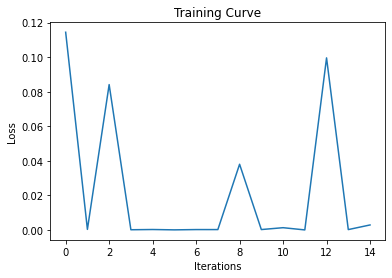

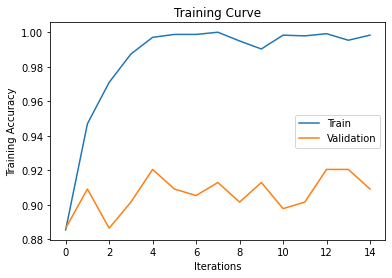

Final Training Accuracy: 0.9983143699957859
Final Validation Accuracy: 0.9090909090909091


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=64, num_epochs=15, learning_rate=0.00007)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch 0 - Training Accuracy: 0.3666245259165613, Validation Accuracy: 0.35984848484848486
Epoch 1 - Training Accuracy: 0.7728613569321534, Validation Accuracy: 0.7916666666666666
Epoch 2 - Training Accuracy: 0.8731563421828908, Validation Accuracy: 0.8522727272727273
Epoch 3 - Training Accuracy: 0.9123472397808681, Validation Accuracy: 0.8787878787878788
Epoch 4 - Training Accuracy: 0.943109987357775, Validation Accuracy: 0.8977272727272727
Epoch 5 - Training Accuracy: 0.9696586599241467, Validation Accuracy: 0.8787878787878788
Epoch 6 - Training Accuracy: 0.9793510324483776, Validation Accuracy: 0.9053030303030303
Epoch 7 - Training Accuracy: 0.9873577749683944, Validation Accuracy: 0.9015151515151515
Epoch 8 - Training Accuracy: 0.9945217024863042, Validation Accuracy: 0.8977272727272727
Epoch 9 - Training Accuracy: 0.9966287399915719, Validation Accuracy: 0.9090909090909091
Epoch 10 - Training Accuracy: 0.9962073324905183, Validation Accuracy: 0.9166666666666666
Epoch 11 - Training 

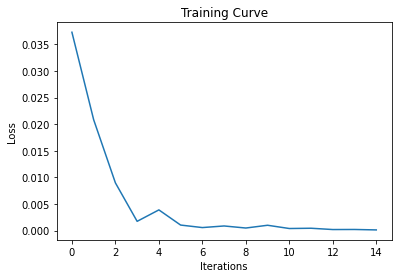

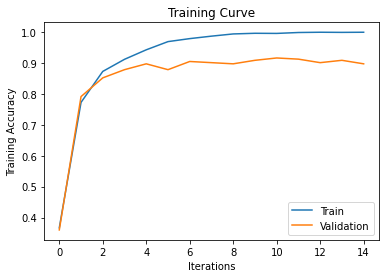

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8977272727272727


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=128, num_epochs=15, learning_rate=0.00003)

Downloading: "https://github.com/pytorch/vision/archive/v0.9.0.zip" to /root/.cache/torch/hub/v0.9.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Epoch 0 - Training Accuracy: 0.7922461019806153, Validation Accuracy: 0.7954545454545454
Epoch 1 - Training Accuracy: 0.909818794774547, Validation Accuracy: 0.875
Epoch 2 - Training Accuracy: 0.9612305099030762, Validation Accuracy: 0.8939393939393939
Epoch 3 - Training Accuracy: 0.9915718499789297, Validation Accuracy: 0.9090909090909091
Epoch 4 - Training Accuracy: 0.9970501474926253, Validation Accuracy: 0.9090909090909091
Epoch 5 - Training Accuracy: 0.9995785924989464, Validation Accuracy: 0.9128787878787878
Epoch 6 - Training Accuracy: 0.999157184997893, Validation Accuracy: 0.9128787878787878
Epoch 7 - Training Accuracy: 1.0, Validation Accuracy: 0.9090909090909091
Epoch 8 - Training Accuracy: 1.0, Validation Accuracy: 0.9166666666666666
Epoch 9 - Training Accuracy: 1.0, Validation Accuracy: 0.9204545454545454
Epoch 10 - Training Accuracy: 1.0, Validation Accuracy: 0.9090909090909091
Epoch 11 - Training Accuracy: 1.0, Validation Accuracy: 0.9090909090909091
Epoch 12 - Training

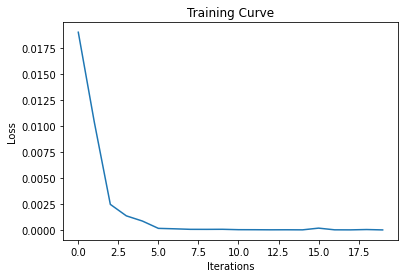

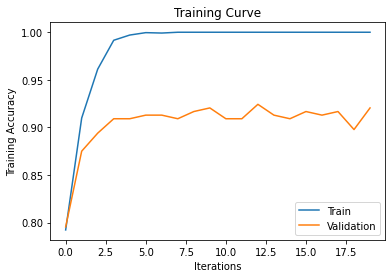

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.9204545454545454


In [ ]:
resnet18_model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
train(resnet18_model.cuda(), batch_size=128, num_epochs=20, learning_rate=0.00007)

In [ ]:
torch.save(resnet18_model.state_dict(), "weights.tar")

# For Testing Later...

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device='cuda')
            y = y.to(device='cuda')
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

In [ ]:
train_loader,val_loader,test_loader,classes = get_data_loader(target_classes=["malignant","benign"],batch_size=128)
check_accuracy(test_loader, resnet18_model)

Got 592 / 660 with accuracy 89.70
